In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Load Data

In [2]:
data = pd.read_csv('Electricity Consumption.csv', parse_dates=['DATE'], date_format="%m/%d/%Y",index_col='DATE')

In [3]:
data=data.reset_index()

In [4]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DATE                          561 non-null    datetime64[ns]
 1   Electricty_Consumption_in_TW  561 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.9 KB


In [6]:
data.isnull().sum()

DATE                            0
Electricty_Consumption_in_TW    0
dtype: int64

In [7]:
data.index.duplicated().sum()

np.int64(0)

In [8]:
# Check for Missing Dates
full_range = pd.date_range(start=data.DATE.min(), end=data.DATE.max(), freq='MS')

# Find missing dates by comparing the full date range with the existing index
missing_dates = full_range.difference(data.DATE)

# Display missing dates
print(missing_dates)

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')


In [9]:
data

,DATE,Electricty_Consumption_in_TW
0,1973-01-01,35.9728
1,1973-02-01,36.1334
2,1973-03-01,35.0625
3,1973-04-01,33.8416
4,1973-05-01,33.5107
...,...,...
556,2019-05-01,97.5860
557,2019-06-01,110.8580
558,2019-07-01,122.1014
559,2019-08-01,121.7765


## Check for Stationarity 

In [10]:
from statsmodels.tsa.stattools import adfuller

# ADF Test
#Null hypothesis
#The time series sample has a unit root, meaning the data mean is not stationary
#Alternative hypothesis
#The time series sample is stationary or trend-stationary

result = adfuller(data['Electricty_Consumption_in_TW'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# p-value >0.05 of ADF test, the null hypothesis can not be rejected. Hence, the series is non-stationary.

ADF Statistic: -1.740593
p-value: 0.410328


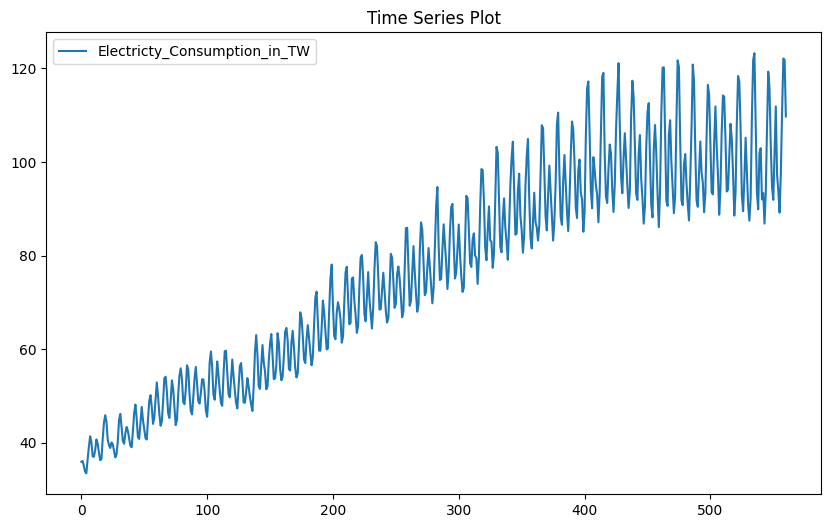

In [11]:
# Plot the time series
plt.figure(figsize=(10, 6))
sns.lineplot(data)
plt.title('Time Series Plot')
plt.show()

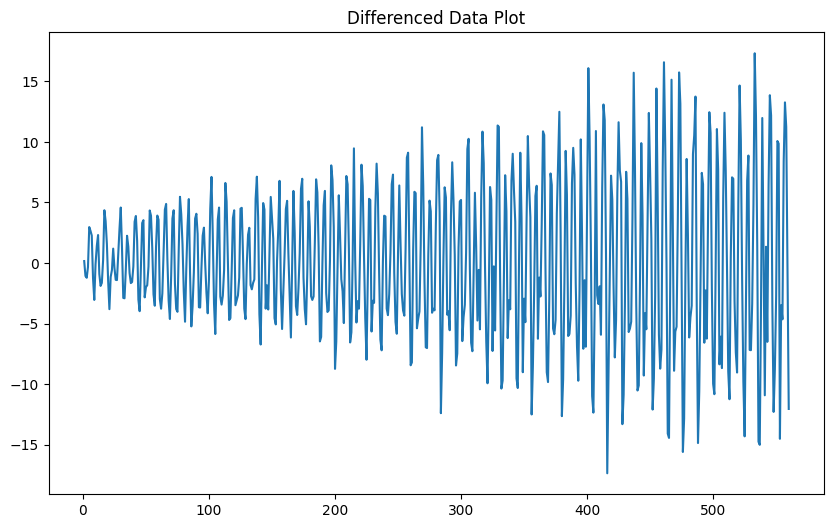

In [12]:
data_diff = data['Electricty_Consumption_in_TW'].diff(periods=1).dropna()

# Plot differenced data
plt.figure(figsize=(10, 6))
plt.plot(data_diff)
plt.title('Differenced Data Plot')
plt.show()

In [13]:
## Decompose the Time Series

In [14]:
data=data.set_index('DATE',drop=False)

In [15]:

data = data.asfreq('MS')

In [16]:
data

,DATE,Electricty_Consumption_in_TW
DATE,,
1973-01-01,1973-01-01,35.9728
1973-02-01,1973-02-01,36.1334
1973-03-01,1973-03-01,35.0625
1973-04-01,1973-04-01,33.8416
1973-05-01,1973-05-01,33.5107
...,...,...
2019-05-01,2019-05-01,97.5860
2019-06-01,2019-06-01,110.8580
2019-07-01,2019-07-01,122.1014


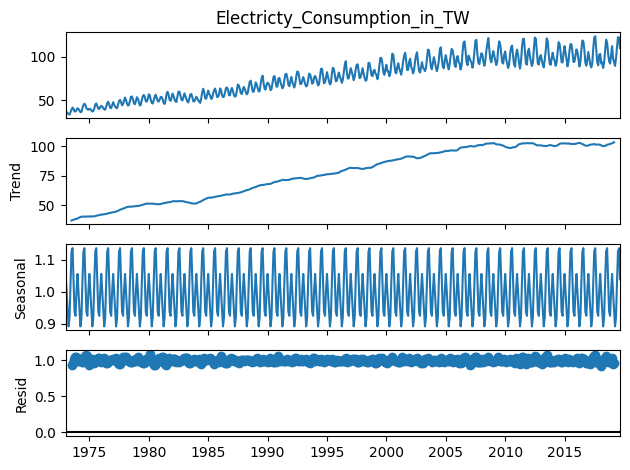

In [17]:

                   
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['Electricty_Consumption_in_TW'],model='mul')
decomposition.plot()
plt.show()

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [18]:
data=data.reset_index(drop=True)

In [19]:
# Train-test split
train, test = data[:448], data[448:]

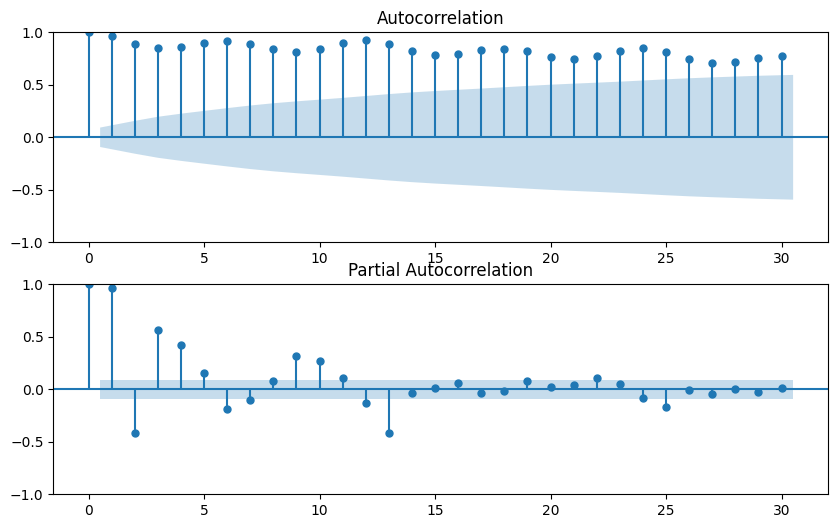

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
fig, ax = plt.subplots(2, figsize=(10, 6))
plot_acf(train['Electricty_Consumption_in_TW'],lags=30, ax=ax[0])
plot_pacf(train['Electricty_Consumption_in_TW'], lags=30, ax=ax[1])
plt.show()

## ARIMA

In [21]:
# fit model on train data
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train["Electricty_Consumption_in_TW"],order=(2, 1, 3)) #p=2,d=1,q=3
arima_fit = model.fit()

In [22]:
train_s=data.copy()

In [23]:
train_s['forecast'] = arima_fit.predict(start=448,end=561,dynamic=True)

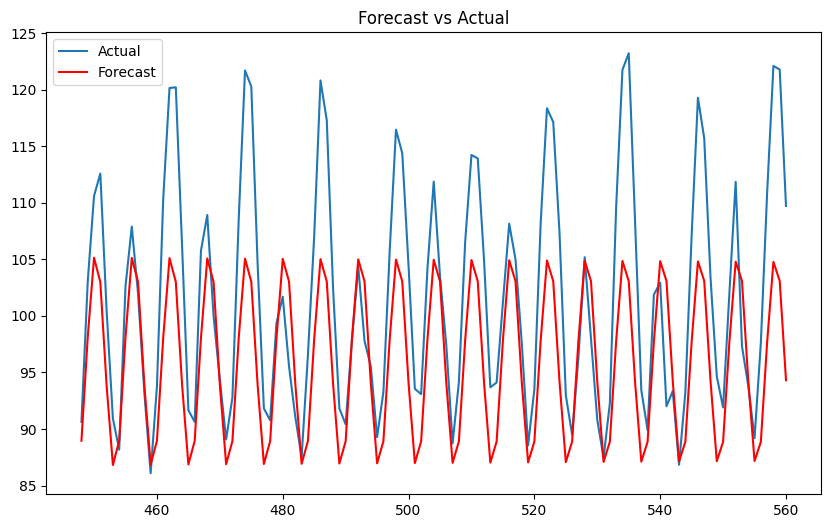

In [24]:
plt.figure(figsize=(10, 6))
plt.plot( train_s["Electricty_Consumption_in_TW"].iloc[448:561], label='Actual')
plt.plot( train_s['forecast'], label='Forecast', color='red')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import  root_mean_squared_error

In [26]:
root_mean_squared_error(train_s.iloc[448:561,1],train_s.iloc[448:561,2])

np.float64(8.331548651790367)

## SARIMAX

In [27]:
# fit model on train data
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train["Electricty_Consumption_in_TW"],order=(2, 1, 3))
sarima_fit = model.fit()

In [28]:
train_s=data.copy()

In [29]:
train_s['forecast'] = sarima_fit.predict(start=448,end=561,dynamic=True)

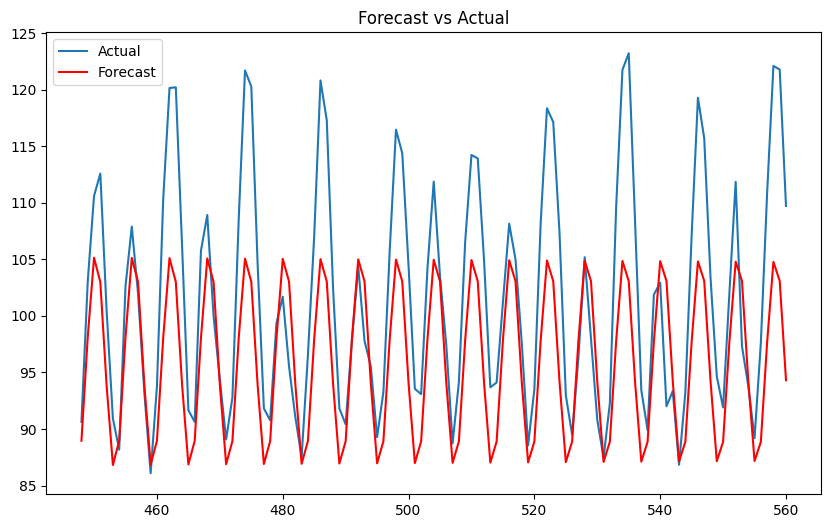

In [30]:
plt.figure(figsize=(10, 6))
plt.plot( train_s["Electricty_Consumption_in_TW"].iloc[448:561], label='Actual')
plt.plot( train_s['forecast'], label='Forecast', color='red')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import root_mean_squared_error

In [32]:
root_mean_squared_error(train_s.iloc[448:561,1],train_s.iloc[448:561,2])

np.float64(8.331548651790367)

## ExponentialSmoothing

In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [34]:
# Fit the model
model = ExponentialSmoothing(train["Electricty_Consumption_in_TW"],trend = 'mul',
                                   seasonal = 'mul',
                                   seasonal_periods = 6)
ets_fit = model.fit()

# Forecast
train_s["forecast"] = ets_fit.forecast(steps=113)

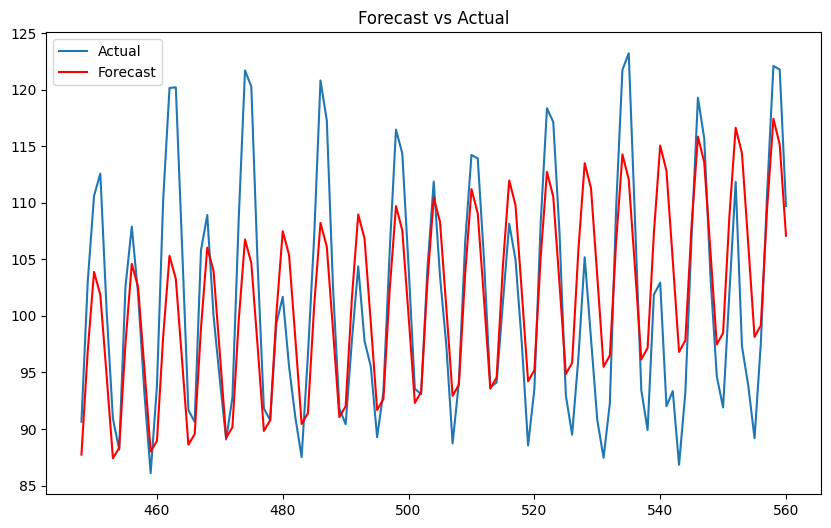

In [35]:
plt.figure(figsize=(10, 6))
plt.plot( train_s["Electricty_Consumption_in_TW"].iloc[448:561], label='Actual')
plt.plot( train_s['forecast'], label='Forecast', color='red')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

In [36]:
root_mean_squared_error(train_s.iloc[448:561,1],train_s.iloc[448:561,2])

np.float64(6.917457696596612)

## RMSE of ETS model is 6.91 lower than ARIMA/SARIMA model which have 8.33

## hence ETS model is selected

In [67]:
full_range = pd.DataFrame(pd.date_range(start="2010-05-01", periods=137, freq='MS'))

In [68]:
f=pd.DataFrame(ets_fit.predict(start=448,end=584)).reset_index(drop=True)

In [69]:
full_range["Forecast"]=pd.DataFrame(f)
full_range.columns = ["DATE","Forecast"]

In [70]:
z=full_range.merge(data, on="DATE",how="left")

In [71]:
z=z.set_index("DATE")

In [74]:
z[-24:]

,Forecast,Electricty_Consumption_in_TW
DATE,,
2019-10-01,98.806740,NaN
2019-11-01,99.845663,NaN
2019-12-01,110.286017,NaN
2020-01-01,118.232167,NaN
2020-02-01,115.937014,NaN
2020-03-01,107.815945,NaN
2020-04-01,99.481337,NaN
2020-05-01,100.527353,NaN
2020-06-01,111.038988,NaN


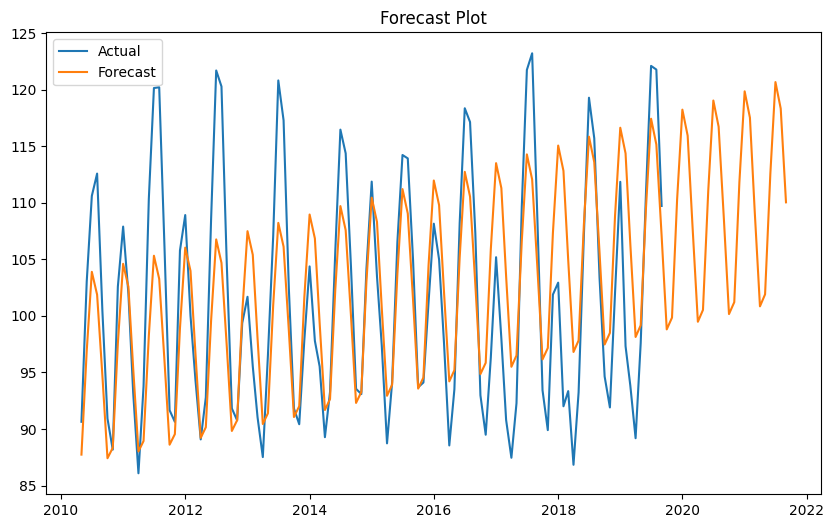

In [75]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(z["Electricty_Consumption_in_TW"],label="Actual")
plt.plot(z["Forecast"],label="Forecast")
plt.title('Forecast Plot')
plt.legend()
plt.show()